In [1]:
!pip install -q \
    numpy \
    pandas \
    scikit-learn \
    matplotlib \
    tslearn \
    xgboost 
        



[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [42]:
import pandas as pd
import os 

import warnings

# 모든 경고를 무시하도록 설정
warnings.filterwarnings('ignore')

forecast = pd.read_csv(os.path.join("Data", "forecast.csv"), index_col=0)
weather = pd.read_csv(os.path.join("Data", "weather.csv"), index_col=0)

pv    = pd.read_csv(os.path.join("Data", "pv_day_merged.csv"), index_col=0)
excol = [col for col in pv.columns if "시간당발전량" not in col]
pv    = pv.drop(columns=excol)
pv_e  = pv[:-24]
test    = pv.iloc[-24:]

merged_factor = weather.join(forecast)

selected_feature = ['지면온도(°C)', '기온(°C)', '풍속', '습도(%)', '남북바람성분', '1시간기온', '습도', '풍향', '동서바람성분']

merged_factor = merged_factor[selected_feature]

# 패턴 군집화

In [3]:
import numpy as np
from tslearn.clustering import TimeSeriesKMeans
import matplotlib.pyplot as plt
import pickle

def create_sequences_set(y, time_steps=24, n_days=1):
    yy, ys = [], []
    for i in range(len(y) - n_days * time_steps):
        yy.append(list(y[i:i + time_steps])+ [y[i + time_steps]])
        ys.append(y[i:i + time_steps])
    return yy, np.array(ys)

def create_sequences_data(X, y, time_steps=24):
    xx, yy =[], []
    for i in range(0, len(y), time_steps):
        xx.append(X[i:i+time_steps])
        yy.append(y[i:i+time_steps])
    
    return np.array(xx), np.array(yy)


k = 15

for name in pv_e.columns:
    pv_data = pv_e[name]

    # 입출력 분리
    y = pv_data  # 건물동 발전량

    # 시퀀스
    time_steps = 24
    _, seq_y = create_sequences_data(merged_factor, y, time_steps=24)
    seq_y = np.array(seq_y).reshape(len(seq_y), 24)


    model = TimeSeriesKMeans(n_clusters=k, metric="dtw", verbose=0, max_iter=10, dtw_inertia=True, random_state=123, tol=0.001, n_jobs=-1, n_init=10)
    y_pred = model.fit_predict(seq_y)

    # 모델 저장
    with open(os.path.join("Data","model_kmeans", f'timeseries_kmeans_pv_{name.replace("/", "")}.pkl'), 'wb') as f:
        pickle.dump(model, f)

    # 모델 불러오기
    with open(os.path.join("Data","model_kmeans", f'timeseries_kmeans_pv_{name.replace("/", "")}.pkl'), 'rb') as f:
        loaded_model = pickle.load(f)


In [4]:
# # sz = y_pred.shape[0]
# sz = time_steps

# for yi in range(k):
    
#     # plt.subplot(10, 5, 1 + yi)
#     plt.figure(figsize=(8, 8))
#     for xx in seq_y[y_pred == yi]:
#         plt.plot(xx.ravel(), "k-", alpha=.2)
#     plt.plot(model.cluster_centers_[yi].ravel(), "r-")
#     plt.xlim(0, sz)
#     plt.ylim(0, 200)
#     plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
#              transform=plt.gca().transAxes)
#     if yi == 1:
#         plt.title("DBA $k$-means")

# xgb 모델 생성

In [45]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import pickle
from sklearn.model_selection import GridSearchCV

# k = 10

factor = merged_factor.copy()
factor = factor[factor.index <= "2023-08-30"]
factor.index = pd.to_datetime(factor.index) + pd.DateOffset(hours=24)

scaler_dict = {}

for name in pv_e.columns:
    
    # 모델 불러오기
    with open(os.path.join("Data","model_kmeans", f'timeseries_kmeans_pv_{name.replace("/", "")}.pkl'), 'rb') as f:
        loaded_model = pickle.load(f)

    # 라벨
    pv_data = pv_e[name]

    pv_df = pd.DataFrame(pv_data)
    fore_data = pv_df[:-24].values # day before pv
    pv_df = pv_df[pv_df.index >= "2022-07-02"]
    pv_df.index = pd.to_datetime(pv_df.index)

    
    pv_df_c = pv_df.join(factor)
    pv_df_c["fore"] = fore_data

    # 시계열 데이터로 만들기
    time_steps = 24
    _, seq_y = create_sequences_data(factor, pv_data[:-24], time_steps=time_steps)
    seq_y = np.array(seq_y).reshape(len(seq_y), 24)

    seq_pred = loaded_model.fit_predict(seq_y)

    # X = np.array(load_data[:24]).reshape(1,-1)      # 임시
    # cl_indice = loaded_model.predict(X)

    

    cl_list = []
    scaler_list = []


    for i in range(k):
        cl_indice = i
        a = seq_pred == i
        cl_ = np.where(a == True)[0].tolist()

        # 군집에 해당하는 시계열들의 인덱스 리스트
        cl_list.append(cl_)


        pv_cl_sub = pd.DataFrame(columns=pv_df_c.columns)

        # 군집별로 데이터프레임 추출 후 학습
        for ele in cl_list[int(cl_indice)]:
            si = ele * 24
            ei = (ele+1) * 24

            sub_df = pv_df_c.iloc[si:ei]
            pv_cl_sub = pd.concat([pv_cl_sub, sub_df], axis=0)


        X = pv_cl_sub.drop(columns=name)
        y = pv_cl_sub[name]


        # 데이터 스케일링
        scaler = MinMaxScaler()
        scaled_X = scaler.fit_transform(X)

        y_scaler = MinMaxScaler()
        scaled_y = y_scaler.fit_transform(np.array(y).reshape(-1,1))
        scaler_list.append(y_scaler)


        X_train, X_test, y_train, y_test = train_test_split(scaled_X, scaled_y, test_size=0.2, random_state=42)

        

        # 하이퍼파라미터 그리드 설정
        param_grid = {
            'max_depth': [5, 7, 9],
            'learning_rate': [0.01, 0.1, 0.2],
            'n_estimators': [100, 200, 300],
            'gamma': [0, 0.2, 0.5]
        }

        xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1, verbosity=0)
        grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='r2', verbose=1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_

        y_pred = best_model.predict(X_test)

        # 모델 저장
        best_model.save_model(os.path.join("Data","model_xgb", f'xgb_pv_{name.replace("/", "")}_{cl_indice}.json'))

        # 성능 평가 (평균 제곱 오차)
        mse = mean_squared_error(y_test, y_pred)
        print(f"col: {name}, Mean Squared Error: {mse}")


    scaler_dict[name] = scaler_list


Fitting 3 folds for each of 108 candidates, totalling 324 fits
col: 축구장_시간당발전량, Mean Squared Error: 0.030837388191215634
Fitting 3 folds for each of 108 candidates, totalling 324 fits
col: 축구장_시간당발전량, Mean Squared Error: 0.03331499820385898
Fitting 3 folds for each of 108 candidates, totalling 324 fits
col: 축구장_시간당발전량, Mean Squared Error: 0.043702370887331164
Fitting 3 folds for each of 108 candidates, totalling 324 fits
col: 축구장_시간당발전량, Mean Squared Error: 0.0075415208897036765
Fitting 3 folds for each of 108 candidates, totalling 324 fits
col: 축구장_시간당발전량, Mean Squared Error: 0.022444158653425483
Fitting 3 folds for each of 108 candidates, totalling 324 fits
col: 축구장_시간당발전량, Mean Squared Error: 0.013350278676098205
Fitting 3 folds for each of 108 candidates, totalling 324 fits
col: 축구장_시간당발전량, Mean Squared Error: 0.04256874010871814
Fitting 3 folds for each of 108 candidates, totalling 324 fits
col: 축구장_시간당발전량, Mean Squared Error: 0.007060178436931766
Fitting 3 folds for each of 108 c

# 31일 예측

In [39]:
import pickle
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler

RESULT = []

factor = merged_factor.copy()
factor = factor[factor.index >= "2023-08-30"]
factor = factor[:24]   #30일 데이터
factor.index = pd.to_datetime(factor.index) + pd.DateOffset(hours=24)


for name in pv_e.columns:
    
    test_value = test[name]
    test_df = factor.copy()
    test_df[name] = test_value.values


    data30 = pv_e[name][-24:]   # 군집 분류 위한 30일 데이터

    # 모델 불러오기
    with open(os.path.join("Data","model_kmeans", f'timeseries_kmeans_pv_{name.replace("/", "")}.pkl'), 'rb') as f:
        loaded_model = pickle.load(f)

    # 부하 모형 분류
    cl_indice = int(loaded_model.predict(np.array(data30).reshape(1,-1)))

    X_scaler = MinMaxScaler()
    y_scaler = scaler_dict[name][cl_indice]

    X = test_df.drop(columns=name)
    y = test_df[name]

    test_X = X_scaler.fit_transform(X)
    # test_y = y_scaler.fit_transform(np.array(y).reshape(1,-1))[0]
    
    # xgb-k 모델 불러오기
    xgbk = xgb.Booster()
    xgbk.load_model(os.path.join("Data","model_xgb", f'xgb_pv_{name.replace("/", "")}_{cl_indice}.json'))

    # 예측
    dtest = xgb.DMatrix(test_X)
    y_pred = xgbk.predict(dtest)

    output = y_scaler.inverse_transform(y_pred.reshape(1,-1))
    RESULT.append(output)

    # 성능 평가 (평균 제곱 오차)
    mse = mean_squared_error(y, output.tolist()[0])
    print(f"Mean Squared Error: {mse}")

Mean Squared Error: 1219.4549990838948
Mean Squared Error: 140.4465028666614
Mean Squared Error: 104.56815322718292
Mean Squared Error: 51.69363436282785
Mean Squared Error: 111.68963323098815
Mean Squared Error: 1744.066368462398
Mean Squared Error: 0.07105430532427583
Mean Squared Error: 151.68013773749576
Mean Squared Error: 97.7504410538192
Mean Squared Error: 272.54250124953813
Mean Squared Error: 80.24732988416979
Mean Squared Error: 242.75755566099744
Mean Squared Error: 740.9093848129361
Mean Squared Error: 716.5844553213452
Mean Squared Error: 110.73492187484027
Mean Squared Error: 2159.2889447282228


In [40]:
result = np.zeros((1,24))
for v in RESULT:
    result = result + v

pd.DataFrame(result.reshape(24,1), columns=["pv"]).to_csv(os.path.join("result", "PV_RESULT.csv"))

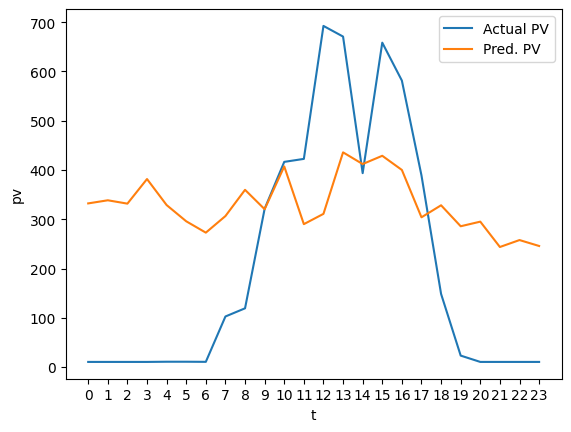

In [41]:
result_ = result.tolist()[0]
test_ = test.sum(axis=1)

plt.xlabel('t')
plt.ylabel('pv')
plt.xticks(ticks=[i for i in range(24)], labels=[i for i in range(24)])

plt.plot(test_, label="Actual PV")
plt.plot(result_, label="Pred. PV")
plt.legend()